# Education ROI and Graduate Outcomes Analysis in Canada
This analysis explores the return on investment (ROI) of postsecondary education in Canada by field of study, integrating education, income, and labour market data. Our goal is to mainly inform students about the long-term value of different educational paths at undergraduate level—helping them to make data-driven decisions about their fututre. Additionally, the analys would offer insights for policymakers to align educational offerings with labour market demand.

We aim to answer key questions:
* Which fields offer the best financial return relative to degree cost (tuition over 4 years)?
* Are some fields oversaturated with graduates relative to employment opportunities?
* Do tuition costs reflect real-world outcomes like income or job stability?

Ultimately, this project would help identify high-value programs, highlight potential risks (like education bubbles), and support better policy and personal decision-making.

In [1]:
import pandas as pd
import numpy as np
from visuals import plots

import importlib
importlib.reload(plots)

<module 'visuals.plots' from 'C:\\Users\\ngoum\\Documents\\coding\\data_projects\\graduate-roi-canada\\visuals\\plots.py'>

## 1. Load Datasets and Merge Datasets

In [2]:
ed_outcomes_data = pd.read_csv("data/postsecondary_field_outcomes.csv")

In [3]:
labour_snapshots = pd.read_csv("data/labour_market_snapshot.csv")

Merge Datasets

In [4]:
ed_outcomes_data = ed_outcomes_data.rename(columns={
    "Nearest Census Year": "Census Year"
})

In [5]:
data = ed_outcomes_data.merge(
    labour_snapshots,
    on=["Field of study", "Census Year"],
    how="left"
)

We concentrate on undergraduate education, as this is the level at which most individuals make critical decisions about field of study, and where questions around the return on investment (ROI) in education are most common. Additionally, the majority of the population does not pursue graduate studies, making undergraduate outcomes the most broadly relevant.

In [6]:
data = data[data["Education Level Group"] == "Undergraduate"]

To accurately calculate ROI, we need a realistic estimate of the total cost of an undergraduate degree. Instead of using a single semester’s tuition, we computed a 4-year rolling sum per field of study to reflect the full tuition paid over a typical program. This provides a more accurate and meaningful measure of educational investment.

In [7]:
data = data.sort_values(["Field of study", "Year"])

In [8]:
# Compute annual tuition
annual_tuition = data["Tuition"] * 2

# Compute cummulative tuition cost over 4 years
data["Degree Cost"] = (
    data.groupby("Field of study")["Tuition"]
        .rolling(window=4, min_periods=4)
        .sum()
        .reset_index(level=0, drop=True)
)

Our primary analysis focuses on the period from 2012 to 2022, aligning with the most recent available census labour force data and median income statistics. 

In [9]:
data.loc[~data["Median income"].isnull(), "Year"]

36     2012
39     2013
42     2014
45     2015
48     2016
       ... 
468    2018
471    2019
474    2020
477    2021
480    2022
Name: Year, Length: 77, dtype: int64

In [10]:
data = data[data["Year"].between(2012,2022)]

For easy visualization, we simplify or abbreviate the fields of studies names

In [11]:
field_name_mapping = {
    'Architecture & Engineering': 'Arch & Eng',
    'Arts and Humanities': 'Arts & Hum',
    'Business & Public Admin': 'Bus & Admin',
    'Education': 'Education',
    'Health': 'Health',
    'Mathematics & CIS': 'Math & CIS',
    'Social Sciences and Law': 'SocSci & Law'
}

data["Field (Long)"] = data["Field of study"].copy()
data["Field of study"] = data["Field of study"].map(field_name_mapping)

## 2. Compute Derived Metrics
To evaluate the value and labour outcomes of each field of study, we compute a series of derived metrics. These indicators capture the relationship between tuition costs, graduate numbers, employment statistics, and income, allowing us to assess ROI, market saturation, and growth trends across disciplines.

| Metric                  | Definition                         | Why It Matters                              |
|-------------------------|------------------------------------|---------------------------------------------|
| ROI                     | Median Income ÷ Cumulative Tuition | Core value proposition for students         |
| Graduate Share          | % of grads by field                | Reveals popularity and education trends     |
| Graduate Growth Rate    | Year-over-year % change            | Tracks student demand over time             |
| Tuition Inflation       | Year-over-year tuition change      | Flags rising costs for students             |
| Employment Stability Index (ESI) | Employment rate ÷ Participation rate | Measures employment stability and security |

#### ROI (Return on Investment)
Measures return on investment for education — how much income is earned per tuition dollar. A higher ROI indicates better returns on educational investment. This metric is a proxy for [Cost-Benefit Analysis (CBA)](https://en.wikipedia.org/wiki/Cost%E2%80%93benefit_analysis).

In [12]:
data["ROI"] = np.nan
data["ROI"] = data["Median income"] / data["Degree Cost"]

#### Graduate Share (%)
Shows what portion of total graduates (in a year) each field contributes. Highlights dominant vs niche fields in education supply.

In [13]:
data["Graduate Share (%)"] = data["Graduates"] / data.groupby("Year")["Graduates"].transform("sum") * 100

#### Graduate Growth Rate
Tracks year-over-year change in the number of graduates per fields. This highlights emerging or shrinking academic fields. High growth + low ROI can indicate a “bubble,” while low growth + high ROI may signal underinvestment.

In [14]:
data["Graduate Growth Rate (%)"] = data.groupby("Field of study")["Graduates"].pct_change() * 100

#### Tuition Growth/Inflation (%)
Tracks affordability over time. High growth erodes ROI unless income increases faster. This metric is tracked by Statistics Canada, OECD, and institutional budget planning.

In [15]:
data["Tuition Inflation (%)"] = data.groupby("Field of study")["Tuition"].pct_change() * 100

#### Employment Stability Index (ESI)
The Employment Stability Index (ESI) is a quick indicator of how stable and secure employment is for graduates of a particular field. A higher ESI means graduates are more likely to be employed and less likely to face joblessness. It reflects both job availability and resilience to unemployment.
* ESI ≈ 1.0 → Nearly everyone in the labor force has a job (very stable)
* ESI < 0.9 → A growing portion of the labor force is unemployed (less stable)

In [16]:
data["ESI"] = data["Employment rate"] / (data["Participation rate"] + 1e-8)

In [17]:
f'ESI range: {data["ESI"].min():.3f} - {data["ESI"].max():.3f}'

'ESI range: 0.896 - 0.971'

## 3. Data Analysis

### 3.1. Education Landscape Overview (2022)
This section provides a snapshot of the distribution of graduates across fields of study at the undergraduate level. The goal is to understand which disciplines are the most popular among students and how graduate output is spread across fields.

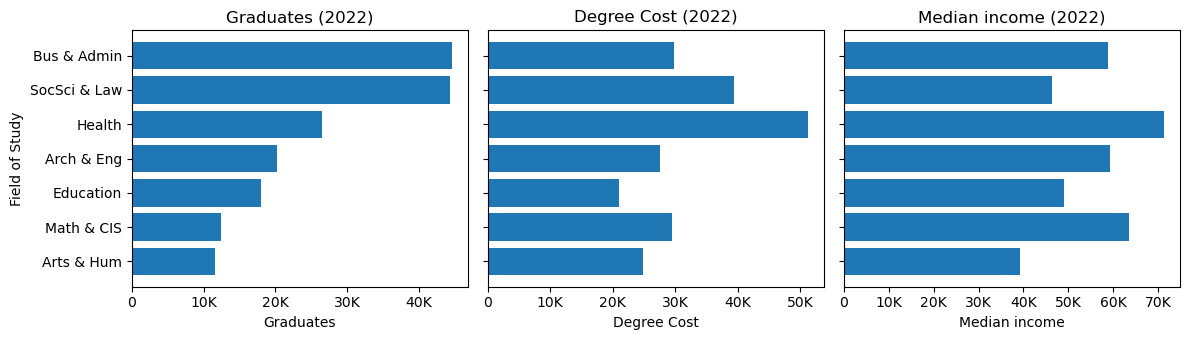

In [18]:
plots.plot_snapshot_metrics(data, metrics=["Graduates", "Degree Cost", "Median income"])

In 2022, **Business & Public Administration** and **Social Sciences & Law** dominated undergraduate education, each producing roughly **25% of all graduates**. Meanwhile, **Health** accounted for a **smaller share (15%)** but led all fields in both tuition costs and median income, suggesting a **high-cost, high-reward dynamic**. Fields like **Arts & Humanities** and **Education** had relatively low tuition, but also reported the lowest median incomes, highlighting potential **concerns around economic return**. **Mathematics & Computer Science** stood out with a **strong income-to-tuition ratio**, suggesting efficient value for students despite moderate enrollment.

### 3.2. Trend Analysis

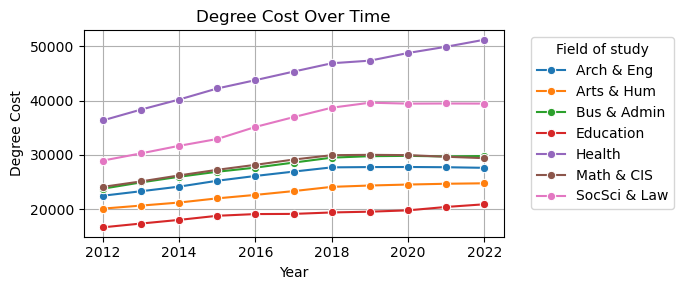

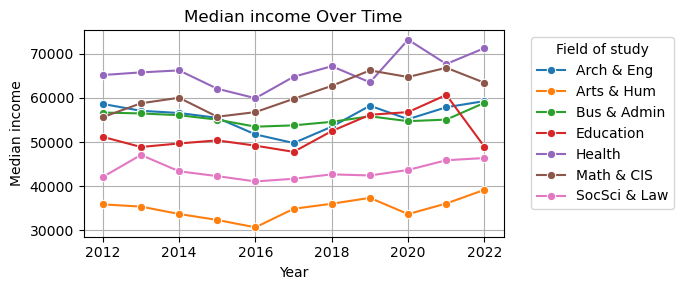

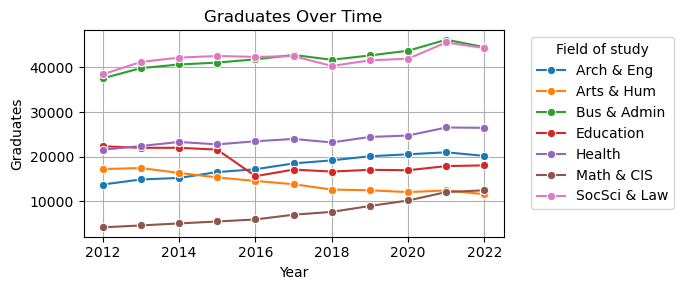

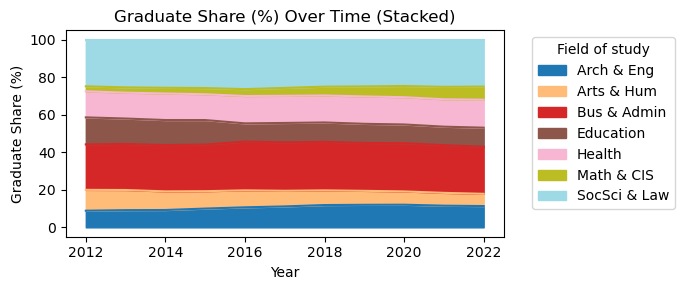

In [19]:
for metric in ["Degree Cost", "Median income", "Graduates", "Graduate Share (%)"]:
    plots.plot_single_trend_metric(data, metric=metric, height=3, width=7)

* From 2012-2022, graduation numbers increased accross most fields, but some fields like **Arts & Humanities** saw a sharp decline in graduate share, dropping from over 11% to around 6.5%. In contrast, **Math & CIS** more than doubled its share, thus signaling a growing interest.
* In the same period of time, degree costs (4 years worth of tuition) rose steadily across all fields until around 2020 before starting to plateau in more recent years. There is an exception for **Health** for which tuition cost continues to steadily increase, rising by around 41% in a decade. Fields such as **Health** and **Social Sciences & Law** remain the most expensive, while **Education** and **Arts & Humanities** are on the lower-cost end.
* Median income trends show modest growth overall, with **Math & CIS** and **Health** offering the highest income levels by 2022, while **Arts & Humanities** remains the at the bottom.
* These trends suggest that technical and professional fields (e.g., **Math & CIS**) are becoming more valuable and attractive, while **humanities-oriented** fields are losing ground in both student interest and financial return.

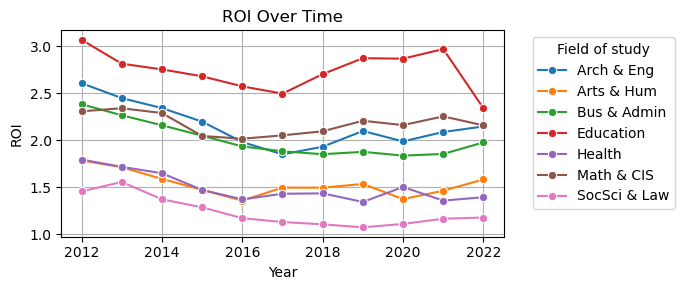

In [20]:
plots.plot_single_trend_metric(data, metric="ROI", height=3, width=7)

Over a decade (2012-2022), **Math & CIS** and **Architecture & Engineering** showed consistently strong and stable ROI, thus reinforcing their position as high-value, lowe-risk fields for students. **Education** maintained the highest ROI for most of the decade, though a noticeable drop in 2022 suggests a potential risk that warrant further analysis with more recent data. Meanwhile, **Busimess & Administration** showed a gradual decline with a mild recovery, offering moderate value. In constrast, **Health** exhibited lopw and declining ROI despite strong income, thus indicating the disparity between degree cost and financial return. At last, **Arts and Humanities** and **Social Sciences & Law** had the lowest and most stagnant ROIs, raising concerns about their long-term value and potential oversaturation in the job market.

### 3.3. Value Analysis (ROI, Income, Degree Cost)
In this section, we identify which undergraduate fields offer the best financial return, affordability, and value relative to tuition, using ROI, income, degree cost (4 years worth of tuition), and graduate share. To ensure a balance between recency and stability, we averaged key metrics over the four most recent years (2019–2022). This approach smooths out short-term fluctuations while still reflecting current tuition costs, income levels, and employment outcomes relevant to today’s students. It would provide a more reliable basis for comparing fields than using a single year, without diluting the insight with older, potentially outdated data.

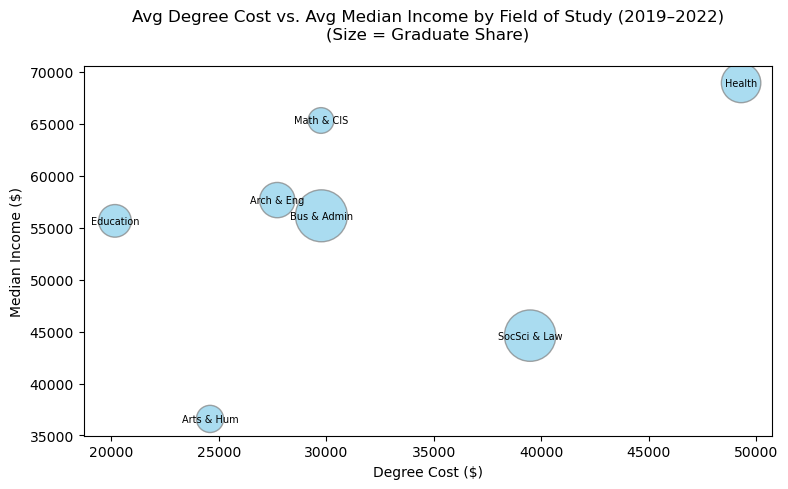

In [21]:
plots.plot_income_vs_tuition_bubble(data, height=5, width=8, bubble_size=55, num_years=4)

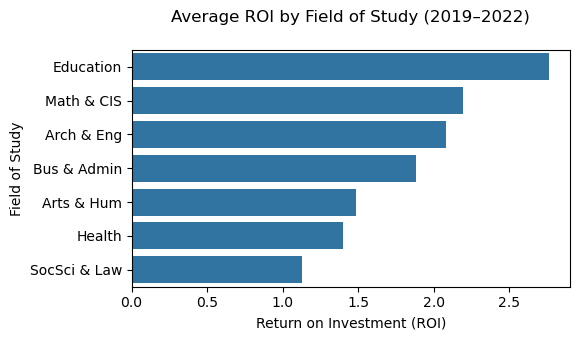

In [22]:
# Plot ROI
plots.plot_roi_by_field(data, height=3.5, width=5.9, num_years=4)

A bubble plot comparing average degree cost and median income (averaged over 4 years) reveals clear differences in the financial efficiency of each field. **Math & CIS** offers one of the highest incomes for a mid-range cost, making it a top-value field despite a smaller graduate share. Meanwhile, **Education** stands out as the most cost-effective option, delivering solid income at the lowest cost. While yielding the highest income, **Health** also comes with the highest cost, reducing its overall return on investment. **Business & Administration** and **Architecture and Enguineering** appear well-balanced with moderate income and cost, reflected in their large graduate share. In contrast, **Social Sciences & Law** offers the least ROI—high in cost but low in income—raising concerns given its high popularity. Similarly, **Arts & Humanities** shows low income for a moderate cost, reinforcing earlier concerns about its long-term financial value.

### 3.4. Market Fit
This section assesses how well undergraduate programs align with job market demand. Using metrics like the Saturation Index and Employment Stability Index, we identify fields that may be oversupplied or offer more stable employment—helping students make informed choices and guiding policy alignment. Metrics are averaged over the three most recent years (2019–2022) to reflect current trends while minimizing short-term fluctuations.

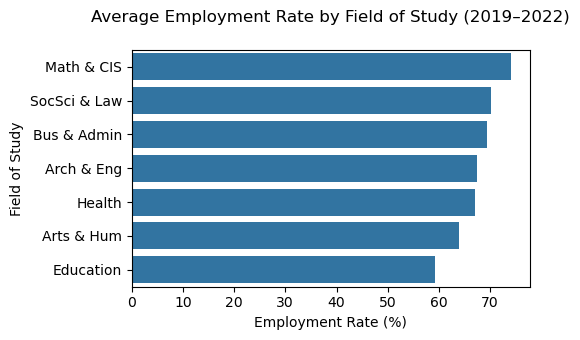

In [23]:
# Plot Employment rate
plots.plot_employment_rate_by_field(data, height=3.5, width=5.5, num_years=4)

A barchart of the average employment rate (2019-2022) reveals that **Math & CIS** leads all fields with the highest job absorption, reinforcing its position as a high-value, high-demand discipline. Similarily, **Business & administration** and **Social Sciences & Law** also show strong employment outcomes. In contrast, **Architecture & Engineering** and **Health** present a relatively moderate employment rates (possibly due to specialization bottlenecks or limited opportunities). Notably, **Arts & Humanities** and especially **Education** show the lowest employment rates, indicating a potential mismatch between high educational value and limited labour market absorption.

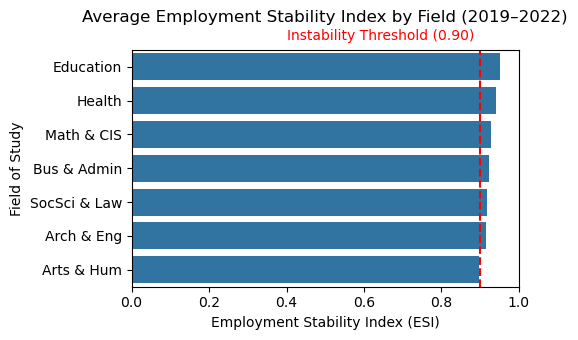

In [24]:
plots.plot_esi_by_field(data, height=3.5, width=5.5, num_years=4)

* The average Employment Stability Index (ESI) from 2019 to 2022 shows that **Education**, **Health**, and **Math & CIS** offer the most stable employment outcomes, with ESI values well above the 0.9 threshold—indicating that a high proportion of those participating in the labour force are actually employed.
* **Business & Administration**, **Social Sciences & Law**, and **Architecture & Engineering** also remain above the threshold, though with slightly lower stability.
* **Arts & Humanities** is the only field below the 0.9 cutoff, suggesting a higher risk of underemployment or labour market mismatch among graduates.

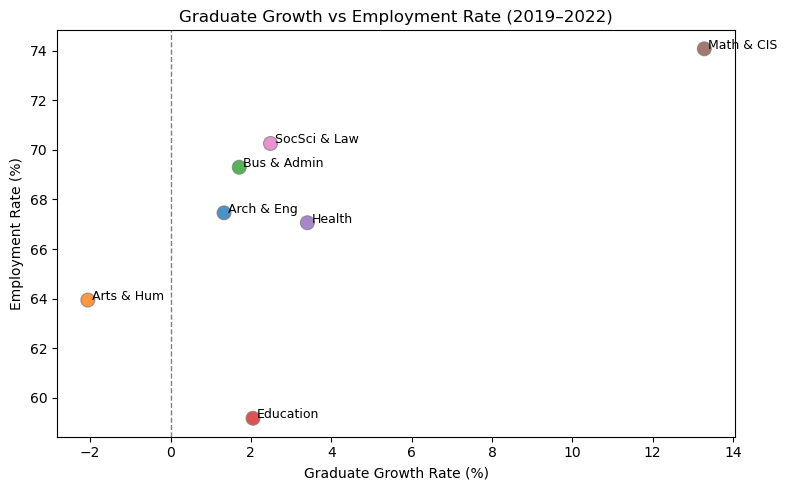

In [25]:
plots.plot_grad_growth_vs_employment(data, height=5, num_years=4)

* **Math & CIS** shows both the highest graduate growth and highest employment rate, indicating strong alignment with labour market demand.
* Other fields like **Business & Administration**, **Social Sciences & Law**, and **Architecture & Engineering** show moderate growth with solid employment, reflecting relatively stable market alignment.
* **Education** has high graduate growth but the lowest employment rate, suggesting a risk of oversupply.
* **Arts & Humanities** is the only field with declining graduate numbers and also has below-average employment, signaling declining interest and weak job prospects.

### 3.5. Summary Table: Field Comparison & Risk Assessment

To help students make informed, data-driven decisions about their educational path, this section presents a summary table that compares key metrics across fields of study. The table includes averages of core indicators over the past four years—ROI, degree cost, income, employment rate, and graduate growth rate—to balance short-term fluctuations with longer-term trends. These metrics are synthesized into a "Risk Flag", which categorizes each field based on a set of practical, transparent thresholds designed to highlight areas of concern or strength.
* ✅ Strong / Stable: Fields with high ROI (≥ 2.0) and strong employment (≥ 70%), with either sustainable or steady growth—low-risk, high-value options.
* ✅ Balanced: Fields with decent ROI (≥ 1.5) and employment (≥ 65%)—reliable and well-rounded choices.
* ⚠️ Monitor: Fields with growing student interest but ROI < 2.0—watch for signs of oversupply or limited return.
* ⚠️ High Cost: Fields where ROI is below 2.0 and tuition exceeds $40,000—income may not justify the investment.
* ⚠️ Limited Jobs: Fields with decent ROI but low employment rates (< 65%)—may require caution due to limited job absorption.
* ❗ Bubble Risk / Risky: Fields with both low ROI (< 1.5) and either rising graduate numbers or weak employment—highest concern for oversaturation and low return.

These flag levels are not final verdicts but rather indicators to support decision-making. A field marked as “⚠️ High Cost” may still be worthwhile for students with strong personal or professional reasons, while a “❗ Risky” flag signals a need to carefully weigh the investment against expected outcomes.

In [30]:
from IPython.display import display

The thresholds used in the summary table are based on practical financial and labour market logic. An ROI of 2.0 or higher indicates strong value, meaning graduates earn at least twice what they paid in tuition. An employment rate below 65% flags difficulty finding work, while a graduate growth rate above 2% may suggest oversupply if not matched by job demand. Fields with tuition over $40,000 but low ROI raise cost-effectiveness concerns. Together, these thresholds help identify which programs offer good long-term value and which may carry financial or market risk.

In [26]:
def assign_risk_flag(row):
    # Thresholds
    low_roi = row["ROI"] < 1.5
    moderate_roi = row["ROI"] < 2.0
    high_cost = row["Degree Cost"] > 40000
    low_employment = row["Employment rate"] < 65
    oversupply = row["Graduate Growth Rate (%)"] > 2

    # Logic
    if low_roi and low_employment:
        return "❗ Risky"
    elif low_roi and oversupply:
        return "❗ Bubble Risk"
    elif moderate_roi and high_cost:
        return "⚠️ High Cost"
    elif not low_roi and low_employment:
        return "⚠️ Limited Jobs"
    elif not low_roi and oversupply and moderate_roi:
        return "⚠️ Monitor"
    elif row["ROI"] >= 2.0 and row["Employment rate"] >= 70 and not oversupply:
        return "✅ Stable"
    elif row["ROI"] >= 1.5 and row["Employment rate"] >= 65:
        return "✅ Balanced"
    else:
        return "✅ Strong"

In [37]:
def build_summary_table(data, num_years=4):
    latest_year = data["Year"].max()
    recent_data = data[data["Year"] >= latest_year - num_years + 1]

    # Compute average metrics per field
    summary = recent_data.groupby("Field (Long)").agg({
        "ROI": "mean",
        "Degree Cost": "mean",
        "Median income": "mean",
        "Employment rate": "mean",
        "Graduate Growth Rate (%)": "mean"
    }).reset_index()

    # Round for presentation
    summary = summary.round({
        "ROI": 2,
        "Degree Cost": 0,
        "Median income": 0,
        "Employment rate": 2,
        "Graduate Growth Rate (%)": 2
    })

    # Assign risk flags
    summary["Risk Flag"] = summary.apply(assign_risk_flag, axis=1)

    summary = summary.rename(columns={"Field (Long)": "Field of study"})

    return summary

In [45]:
def display_summary_table(summary_df, style=True):
    # Format columns
    formatted = summary_df.copy()
    formatted["ROI"] = formatted["ROI"].apply(lambda x: f"{x:.2f}")
    formatted["Employment rate"] = formatted["Employment rate"].apply(lambda x: f"{x:.1f}")
    formatted["Degree Cost"] = formatted["Degree Cost"].apply(lambda x: f"${int(x):,}")
    formatted["Median income"] = formatted["Median income"].apply(lambda x: f"${int(x):,}")
    formatted["Graduate Growth Rate (%)"] = formatted["Graduate Growth Rate (%)"].astype(str) + "%"

    formatted = formatted.sort_values(by="ROI", ascending=False)
    formatted = formatted.reset_index(drop=True)

    if not style:
        display(formatted)
        return

    # Styled display
    styled = formatted.style\
        .set_properties(**{'text-align': 'left'})\
        .set_caption("📊 Summary Table – Field Performance & Risk Assessment")

    display(styled)

In [38]:
summary_df = build_summary_table(data, num_years=4)

In [39]:
summary_df["Risk Flag"] = summary_df.apply(assign_risk_flag, axis=1)

In [46]:
display_summary_table(summary_df)

,Field of study,ROI,Degree Cost,Median income,Employment rate,Graduate Growth Rate (%),Risk Flag
0,Education,2.76,"$20,172","$55,662",59.2,2.05%,⚠️ Limited Jobs
1,Mathematics & CIS,2.20,"$29,756","$65,325",74.1,13.29%,✅ Balanced
2,Architecture & Engineering,2.08,"$27,722","$57,662",67.5,1.33%,✅ Balanced
3,Business & Public Admin,1.89,"$29,775","$56,150",69.3,1.71%,✅ Balanced
4,Arts and Humanities,1.49,"$24,595","$36,594",63.9,-2.06%,❗ Risky
5,Health,1.40,"$49,298","$68,938",67.1,3.4%,❗ Bubble Risk
6,Social Sciences and Law,1.13,"$39,484","$44,612",70.3,2.49%,❗ Bubble Risk
